<div align="right"><i>COM418 - Computers and Music</i></div>
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

<p style="font-size: 30pt; font-weight: bold; color: #B51F1F;">Non-Harmonic Distortion in a Quantized Sinusoid <br> (Tsividis' Paradox)</p>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import scipy.special as ss
from scipy.io import wavfile
import IPython
import ipywidgets as widgets

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

In [122]:
# helper functions

def play_sound(SF, s, volume=1):
    # play a sound with a volume factor
    x = np.copy(s) * volume
    return IPython.display.Audio(x, rate=SF, normalize=False)  

def multiplay(SF, clips, title=None):
    outs = [widgets.Output() for c in clips]
    for ix, clip in enumerate(clips):
        with outs[ix]:
            print(title[ix] if title is not None else "")
            display(IPython.display.Audio(clip, rate=SF, normalize=False))
    return widgets.HBox(outs)

def stem(x, color='tab:blue'):
    # stem with chosen color
    markerline, stemlines, baseline = plt.stem(x, use_line_collection=True, basefmt='k');
    markerline.set_color(color)
    stemlines.set_color(color)

# Quantization in A/D conversion

## The classic A/D converter

 * $x(t)$ bandlimited to $F_s/2$
 * sample at $F_s$ Hz
 * uniform quantization with $M$ levels

<center>
<img src="img/sbq.png" style="width: 1200px;"/> 
</center>

## Uniform scalar quantization

 * $M$-level uniform scalar quantizer: $q: \mathbb{R} \rightarrow \{\hat{x}_0, \ldots, \hat{x}_{M-1}\}$
 
 * non-overload region: $[-1,1]$
 * quantization step: $\Delta = 2/M$ 

In [114]:
def quantize(x, M):
    if M == 0:
        return x
    elif M % 2 == 0:
        # using a mid-riser quantizer
        M = M / 2
        k = np.floor(x * M)
        k = np.maximum(np.minimum(k, M-1), -M)
        return (k + 0.5) / M
    else:
        # using a deadzone quantizer
        k = np.round(np.abs(x) * M / 2)
        k = np.minimum((M - 1) / 2, k)
        return (np.sign(x) * k / M * 2 )

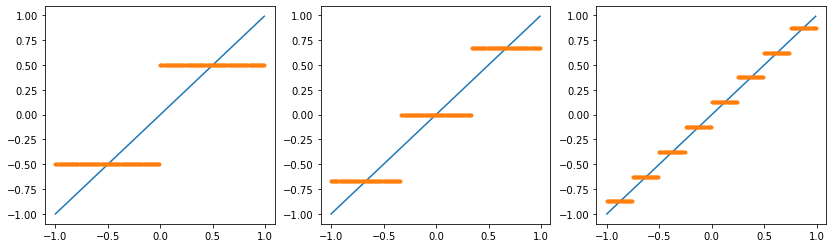

In [115]:
x = np.arange(-1, 1, .01)
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    plt.plot(x,x);    
    plt.plot(x, quantize(x, M), '.');

## High-resolution hypothesis

<center>
<img src="img/linearized.png" style="width: 1200px;"/> 
</center>

 * $e[n]$ white noise uncorrelated with $x[n]$
 * $\sigma_e[n] = \Delta^2/12$
 * $\mathrm{SNR} = 6M~\mathrm{dB}$
    

# Tsividis' paradox


<center><img src="img/sbq.png" style="width: 800px;"/></center>

 * sampling and quantization are memoryless: they can be swapped




 * let's swap them:

<center>
<img src="img/sbq.png" style="width: 800px;"/> 
<img src="img/qbs.png" style="width: 800px;"/> 
</center>

<center>
but $\mathcal{Q}$ discontinuous so $\hat{x}(t)$ no longer bandlimited  $~~\Longrightarrow~~$ aliasing!
</center>

# Harmonic vs non-harmonic distortion

 * $x(t)$ periodic with period $T = 1/f_0$
 * instantaneous distortion function $r(\cdot)$
 
The signal $r(x(t))$ will incur:
 * **harmonic distortion** if the spectral content at integer multiples of $f_0$ is modified <br />(typical of "natural" saturation/clipping)
 * **non-harmonic distortion** if spectral content appear elsewhere <br />(typical of aliasing)
 
In practice:
 * harmonic distortion: bearable, if we really have to
 * non-harmonic distortion: unbearable because totally unnatural

## Total Harmonic Distortion (THD)

THD quantifies harmonic distortion for sinusoidal inputs: $x(t) = \sin(2\pi f_0 t)$

Express $r(x(t))$ via its Fourier **series** since periodicity is preserved: $\displaystyle  r\left(x(t)\right) = \sum_{k=-\infty}^{\infty} c_k\, e^{-j2\pi f_0 k t}$

$$
    \mathrm{THD} = \sqrt{\frac{\sum_{k > 1} |c_k|^2}{|c_1|^2}}
$$

Example: 
 * $r(x) = \mathrm{sgn}(x)$, from sinusoid to square wave (two-level quantization)
 * $\displaystyle \mathrm{sgn}\left(\sin(2\pi f_0 t)\right) = \frac{4}{\pi}\sum_{k = 1}^{\infty}\frac{1}{2k-1}\sin(2\pi(2k-1) f_0 t)$

$$
    \mathrm{THD} = \sqrt{\sum_{k = 2}^{\infty}\left(\frac{1}{2k-1}\right)^2} = \sqrt{\frac{\pi^2}{8}-1} \approx 0.48.
$$

**Exercise:** prove the result

## Non-harmonic distortion: aliasing

Example as before, but in discrete time:
 * $F_s > 2f_0$ 
 * $\omega_0 = f_0/Fs < \pi$
 * $\displaystyle \mathrm{sgn}\left(\sin(\omega_0 n)\right) = \frac{4}{\pi}\sum_{k = 1}^{\infty}\frac{1}{2k-1}\sin((2k-1) \omega_0 n)$
 * frequencies for $k > (1 + \pi/\omega_0) / 2$ will be aliased! 


## Harmonic vs non-harmonic distortion: example

progressively harder clipping vs progressively coarser quantization

In [124]:
sf, f0, M = 8000, 440, 9

# one second per clipping level
w = 2 * np.pi * f0 / sf * np.arange(0, M * sf)
x = np.sin(w)
x_c, x_q = np.zeros(len(w)), np.zeros(len(w))

for n, level in enumerate(range(M, 1, -1)):
    s = slice(n * sf, (n + 1) * sf)
    # progessively harder clipping
    x_c[s] = np.clip(np.sin(w[s]), -level/M, level/M) * M / level
    # progressively coarser quantization
    x_q[s] = quantize(np.sin(w[s]), 2 ** level)
    
multiplay(sf, (0.3 * x_c, 0.3 * x_q), ('clipping', 'quantization'))    

## Aside: non-harmonic distortion due to intermodulation

When more than a single sinusoid is considered, things get complicated quickly
 * $r(x) = \sum_{n=0}^{\infty} a_n \, x^n$ (Taylor series expansion)
 * $\sin^n \alpha = \gamma_0 + \sum_{k=1}^{n} \gamma_k \sin k\alpha$ 
 * $\sin \alpha \sin \beta = \mu_0 \sin(\alpha + \beta) + \mu_1 \sin(\alpha - \beta)$
 
$$
    r\left(\sin(2\pi f_0 t)  + \sin(2\pi f_1 t)\right) = \ldots = \sum_{k_0, k_1 = -\infty}^{\infty} b_{k_0, k_1} \sin(2\pi (k_0 f_0 + k_1 f_1) t)
$$

In [125]:
for n, level in enumerate(range(M, 1, -1)):
    s = slice(n * sf, (n + 1) * sf)
    x_c[s] = np.clip((np.sin(w[s]) + np.sin(1.5 * w[s])) / 2, -level/M, level/M) * M / level

play_sound(sf, x_c, volume=0.3)    

# Ravel's Bolero

## An impressive dynamic range

<center>
<img width="800" src="img/bolero_diff.jpg">
</center>


In [129]:
def play_quantized(excerpt, levels):
    SF, s = wavfile.read('snd/' + excerpt + '.wav')
    return play_sound(SF, quantize(s / 32767, levels))

audio_files = ['boleroA', 'boleroZ']
def multiplay_quantized(file_list, levels=None, description=None):
    outs = [widgets.Output() for f in file_list]
    for ix, file in enumerate(file_list):
        with outs[ix]:
            if levels is not None:
                M = levels[ix]
                quant = str(M) + ' levels'
            else:
                M = 0 
                quant = 'full res'
            print(description[ix] if description is not None else file + ', ' + quant)
            M = 0 if not levels else levels[ix]
            display(play_quantized(file, M))
    return widgets.HBox(outs)

In [130]:
multiplay_quantized(['boleroA', 'boleroZ'])

<center>
<img width="1200" src="img/bolero_wav.png">
</center>


 * live performances have an dynamic range of 100dBs or more
 * 16-bit audio covers about 96dBs
 * ... but vinyl is no better: about 70dB dynamic range

## Aside: oreloB

<img width="480" style="float: right;" src="img/orelob.jpg">

Bolero is much louder at the end but vinyls suffer from _end of side_ distortion:
 * rotational speed constant, but inner grooves shorter
 * reading speed gets slower
 * recorded wavelengths become shorter<br/> and comparable to stylus size
 * groove slope gets too steep for tracking
 
Solution: oreloB, a vinyl that plays backwards

## Quantizing the Bolero

<img width="600" style="float: right;" src="img/bolero_wav.png">

 * clearly the beginning spans a much smaller<br />number of quantization levels than the end
 * the high-resolution hypothesis may not hold

In [131]:
multiplay_quantized(['boleroM', 'boleroM'], levels=[2**16, 2**8])

In [132]:
multiplay_quantized(['boleroA', 'boleroA'], levels=[2**16, 2**8])

# Numerical Experiments

## Sampling a sine wave with rational normalized frequency

(the opening flute in the Bolero is close to a pure sinusoid)

 * conventional setup: sampling followed by quantization
 * $x(t) = \sin(2\pi f_0 t)$, sampled at $F_s$ and $f_0 = \frac{A}{B}F_s$ with $A$ and $B$ coprime <br/>
 
 * $x[n] = \sin\left(2\pi\frac{A}{B}n\right)$
 
 
 * $x[n]$ will be periodic with period $B$ and it will span $A$ cycles over $B$ samples
 * natural Fourier representation: DFS $\mathbf{X}\in \mathbb{C}^B$
 * single nonzero coefficient $X[A]$

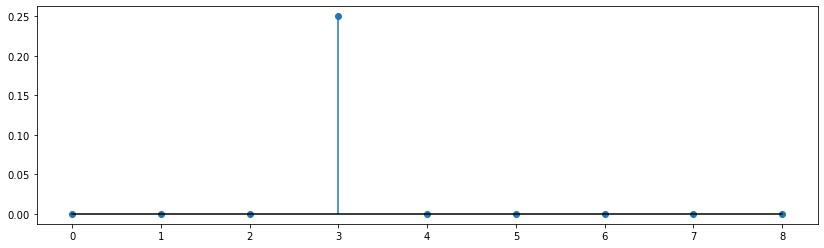

In [134]:
def quantized_sinusoid(A, B, M=0, initial_phase=1):
    # add an initial phase non commensurable with pi to eliminate quantization of zero values
    x = np.sin(initial_phase + 2 * np.pi * ((A * np.arange(0, B)) % B) / B)
    qx = quantize(x, M)
    return {
        'original' : x, 
        'quantized' : qx, 
        # square magnitude of the normalized DFS for positive frequencies
        'DFS' : (np.abs(np.fft.fft(qx))[:int(np.ceil(B/2))] / B ) ** 2 
    }

stem(quantized_sinusoid(3, 17)['DFS'])

## Introducing quantization

 * $\mathbf{x} \rightarrow \hat{\mathbf{x}}$
 * $\hat{\mathbf{x}}$ still periodic with a period of $B$ samples
 
 
Distortion:
 * harmonic distortion will affects the DFS coefficient whose index is a multiple of $A$
 * non-harmonic distortion will affect the other coefficients
 
 
First note in the Bolero is a $C_5$, i.e. 523.25Hz. 

At $F_s=44.1$KHz we can pick $B=257$ and $A=3$. 

In [135]:
def find_nhd(A, dfs, full=False):
    # zero out harmonic components to highlight non-harmonic content
    N = int(np.ceil(len(dfs) / 2)) if full else len(dfs)
    nhd = np.copy(dfs[:N])
    nhd[::A] = 0
    return max(nhd), nhd

In [136]:
def show_nhd(A=3, B=257, M=2):
    s = quantized_sinusoid(A, B, int(M))
    peak, nhd = find_nhd(A, s['DFS'])
    
    plt.subplot(1, 2, 1)    
    plt.plot(s['original']);
    plt.plot(s['quantized']);
    plt.title('signal')
    
    plt.subplot(1, 2, 2)    
    stem(s['DFS'])
    plt.title('DFS')
    
    plt.figure()
    stem(nhd)
    plt.ylim(0, 0.0002)
    plt.title('non-harmonic components, max=' + str(peak))

In [137]:
display(widgets.interactive(show_nhd, M=widgets.Dropdown(options=['2', '3', '4', '128' ]), A=(1, 11), B=widgets.fixed(257)))

interactive(children=(IntSlider(value=3, description='A', max=11, min=1), Dropdown(description='M', options=('…

## Searching for the worst case

 * try to get a sense for how bad non-harmonic distortion can get
 * let's iterate over all non-reducible $A/B$ ratios between $0$ and $1/2$ 
 
 
**Farey sequence** of order $N$ is the sequence of _non-reducible_ fractions in the unit interval with denominator smaller or equal than $N$

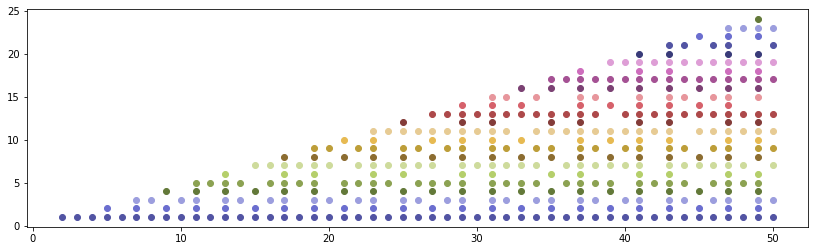

In [138]:
def farey_sequence(n):
    """Build the order-N Farey sequence up to 1/2."""
    farey = []
    (a, b, c, d) = (0, 1, 1, n)
    while (c <= n):
        k = (n + b) // d
        (a, b, c, d) = (c, d, k * c - a, k * d - b)
        farey.append((a, b))
        if a/b >= 0.5:
            break
    return farey


for (a, b) in farey_sequence(50):
    plt.plot(b, a, 'o', color=plt.cm.tab20b(a % 20))

In [139]:
def find_max_nhd(N, M=2, parametric=False):
    max_value = (0, 0, 0)
    for (A, B) in farey_sequence(N):
        peak, _ = find_nhd(A, quantized_sinusoid(A, B, M)['DFS'])
        plt.plot(B if parametric else (A / B), peak, 'o', color=plt.cm.tab20b(A % 20))
        if peak > max_value[0]:
            max_value = (peak, A, B)
    plt.title(f'max value is {max_value[0]}, frequency {max_value[1]}/{max_value[2]}')

## Non-harmonic distortion for Farey ratios

Maximum square magnitude of non-harmonic DFS coefficient as a function of $B$ and parametrized in $A$

![title](img/nhd.png)

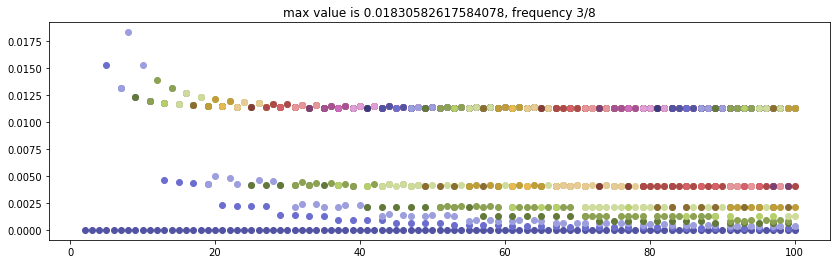

In [18]:
find_max_nhd(100, 2, parametric=True)

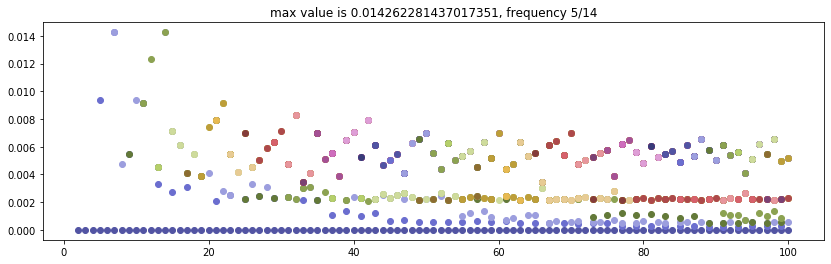

In [19]:
find_max_nhd(100, 3, parametric=True)

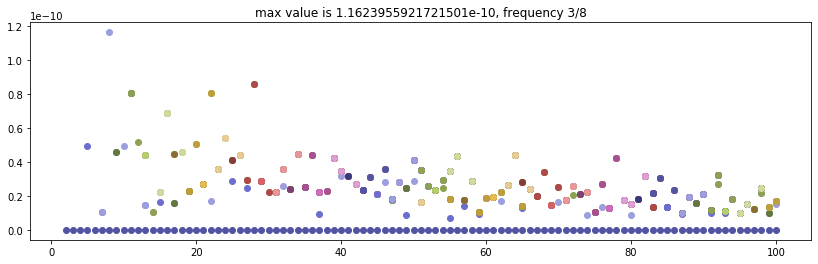

In [20]:
find_max_nhd(100, 32768, parametric=True)

Let's also look at the non-parametrized plots. 

The reason for the step-ladder patterns will be hopefully clear by the end.

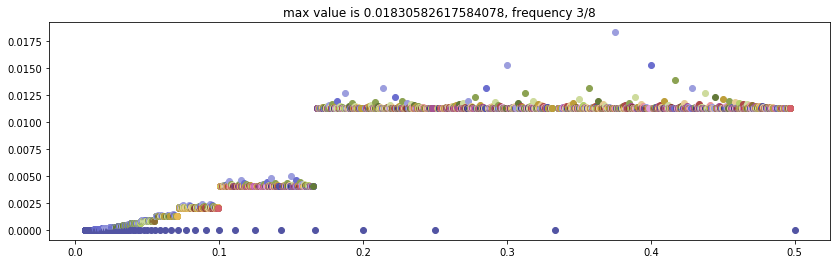

In [21]:
find_max_nhd(150, 2)

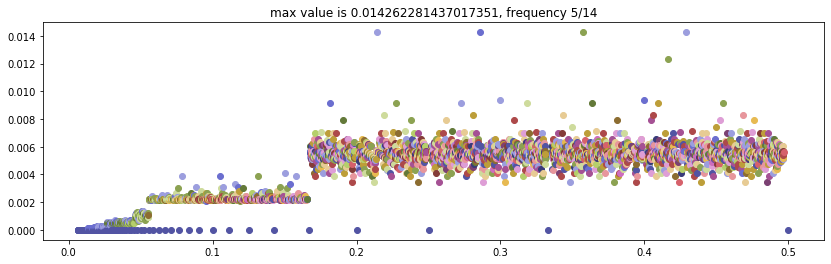

In [22]:
find_max_nhd(150, 3)

# Theoretical Analysis

## Some DSP archeology 

Here is a really interesting paper from 1947

<center>
<img width="1200" src="img/cpg_title.jpg">
</center>

For context, in 1947 this was happening

<br /><br />

<center>
<img width="800" src="img/transistor.jpg">    
</center>

My second favorite quote of the paper:

<center>
<img width="600" src="img/cpg_quote2.jpg">
</center>

My favorite quote of all time:
<br /><br /><br />

<center>
<img width="600" src="img/cpg_quote.jpg">
</center>

### Quantization before sampling    


<center>
<img src="img/qbs.png" style="width: 800px;"/> 
</center>


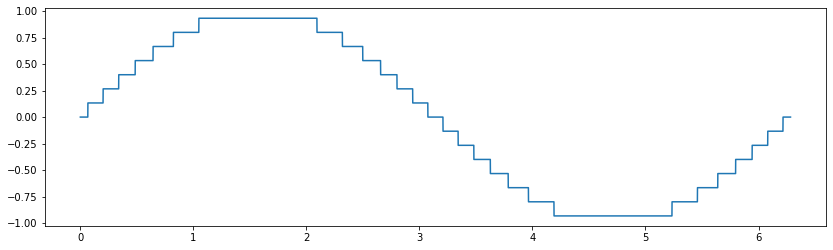

In [23]:
t = np.arange(0, 2 * np.pi, 0.001)
plt.plot(t, quantize(np.sin(t), 15));

<img width="300" style="float: right; margin: 10px;" src="img/clavier.jpg">

Fundamental idea: 


 * decompose this piecewise-constant periodic  <br /> waveform as the sum of $N$ pairs of rectangular steps  <br /> of appropriate width
 * express $\hat{x}(t)$ using a Fourier series expansion:

<br /><br />
$$
  \hat{x}(t) = \sum_{h=1}^{N} \sum_{k=0}^{\infty} \frac{4}{\pi N (2k+1)} \cos\left[(2k+1)\arcsin\left(\frac{2h-1}{2N}\right) \right]\sin((2k+1)t)
$$

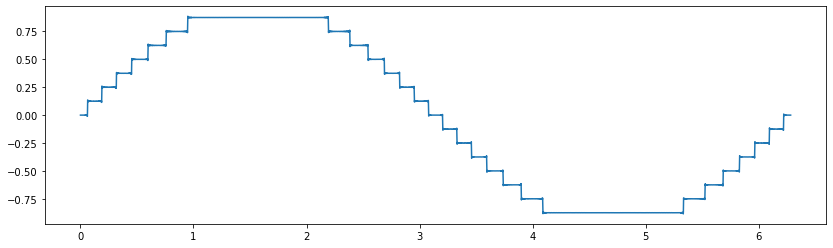

In [140]:
def quantized_sinusoid_fs(N, terms=1000):
    t = np.arange(0, 2 * np.pi, 0.001)
    x = np.zeros(len(t))
    for h in range(1, N):
        for k in range(0, terms):
            x = x + np.cos((2 * k + 1) * np.arcsin((2 * h - 1) / N / 2)) * np.sin((2 * k + 1) * t) / (2 * k + 1)
    x = x * 4 / np.pi / N
    return t, x


plt.plot(*quantized_sinusoid_fs(8));

### Fundamental intuition:

 * $q(\sin(t))$ **contains harmonics at all odd multiples of the fundamental frequency** 
 * quantization of a continuous-time sine wave produces only harmonic distortion
 
 
 
 * NHD is given by spectral lines beyond the Nyquist frequency aliased by the sampler

## More recent times

Moving on to Robert Gray's 1990 paper ["Quantization Noise Spectra"](https://ieeexplore.ieee.org/document/59924).

### The normalized quantization error

 * consider the expression for the _normalized quantization error_
$$
    \eta(x) = \frac{q(x) - x}{\Delta} =  \frac{q(x) - x}{2/M} \quad \in [-0.5, 0.5].
$$
 * $\eta(x)$ is a **periodic** function with period $M/2$

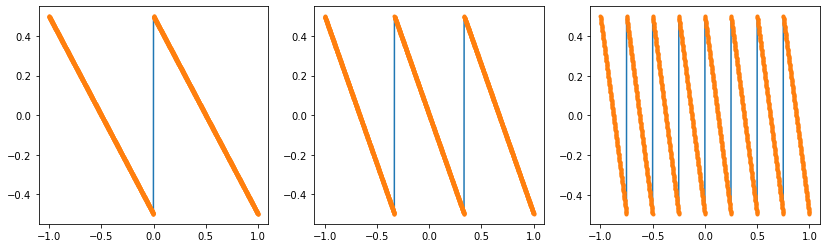

In [142]:
x = np.arange(-1, 1, .001)
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    e = (quantize(x, M) - x) / (2 / M)
    plt.plot(x, e);    
    plt.plot(x, e, '.');

 * $\eta(x)$ can be expressed as a Fourier Series
$$
    \eta(x) = \sum_{k=1}^{\infty} \frac{(-1)^{kM}}{\pi k}\sin\left(\pi k M x\right)
$$
 * $(-1)^{kM}$ is identically one for mid-riser quantizers and alternates in sign for deadzone quantizers.

In [143]:
def nqe_fs(x, M, terms=1000):
    e = np.zeros(len(x))
    s = [1, -1 if M % 2 == 1 else 1]
    for k in range(1, terms):
        e = e + s[k % 2] * np.sin(np.pi * k * x * M) / (np.pi * k)
    return x, e

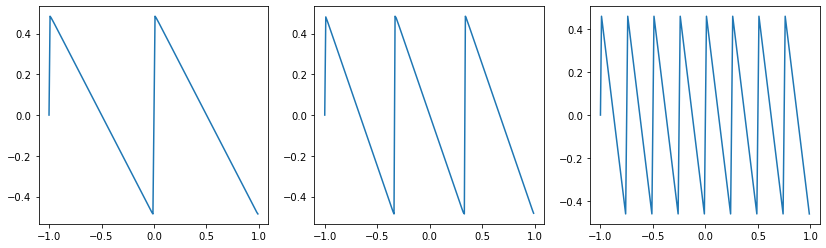

In [144]:
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    plt.plot(*nqe_fs(np.arange(-1, 1, .01), M))

### Quantization noise for a sinusoidal input

 * back to sampling followed by quantization
 * $x[n] = \sin(\omega_0 n + \theta)$ with $0 \le \omega_0 < 2\pi$.  
 * $\eta[n] = \eta(\sin(\omega_0 n + \theta))$ and we are interested in computing its spectrum. 


 * using complex exponentials for the Fourier series:
$$
    \eta(x) = \sum_{k \neq 0} \frac{(-1)^{kM}}{j2\pi k}e^{j\pi k M x}.
$$

Now we need to replace $x$ by $\sin(\omega_0 n + \theta)$ and we end up with terms of the form $e^{j \alpha \sin \beta}$; these can be expanded in terms of Bessel functions using the so-called Jacobi-Anger formula:

$$
    e^{j \alpha \sin \omega} = \sum_{m=-\infty}^{\infty} J_m(\alpha)e^{j\omega m}.
$$

Bessel functions are even or odd according to whether their order is even or odd, so:

$$
\begin{align*}
    \eta[n] = \eta(\sin(\omega_0 n + \theta)) &= \sum_{k \neq 0} \frac{(-1)^{kM}}{j2\pi k}e^{j\pi k M \sin(\omega_0 n + \theta)} \\
      &= \sum_{k \neq 0} \frac{(-1)^{kM}}{j2\pi k} \sum_{m=-\infty}^{\infty} J_m(\pi k M)e^{j (2m+1)\theta} e^{j (2m+1)\omega_0 n} \\
      &= \sum_{m=-\infty}^{\infty} \left[ e^{j (2m+1)\theta} \sum_{k = 1}^{\infty} \frac{(-1)^{kM}}{j\pi k}J_{2m+1}(\pi k M) \right] e^{j (2m+1)\omega_0 n} \\ \\
      &= \sum_{\varphi \in \Omega(\omega_0)} b(\varphi) e^{j \varphi n}
\end{align*} 
$$

$$
    \eta[n] = \sum_{\varphi \in \Omega(\omega_0)} b(\varphi) e^{j \varphi n}
$$

 * $\Omega(\omega_0) = \{(2m+1)\omega_0 \mod 2\pi\}_{m \in \mathbb{Z}}$, i.e., all the odd multiples of the fundamental frequency aliased over the $[0, 2\pi]$ interval;
 
 
 * for each frequency $\varphi \in \Omega(\omega_0)$:
   * $I(\varphi) = \{m \in \mathbb{Z} | (2m+1)\omega_0 \equiv \varphi \mod 2\pi\}$
   
   * $\displaystyle b(\varphi) = \sum_{m \in I(\varphi)} \left[ e^{j (2m+1)\theta} \sum_{k = 1}^{\infty} \frac{(-1)^{kM}}{j\pi k}J_{2m+1}(\pi k M) \right]$

### PSD of the error

$$
    P_{\omega_0}(e^{j\omega}) = \sum_{\varphi \in \Omega(\omega_0)} |b(\varphi)|^2 \delta(\omega - \varphi).
$$

### Case 1: rational normalized frequency

Assume $\omega_0 = 2\pi(A/B)$, with $A$ and $B$ coprime, as in the numerical experiments

 * the set $\Omega(\omega_0)$ is finite: <br /> $\displaystyle\Omega\left(2\pi\frac{A}{B}\right) = \left\{\frac{2i\pi}{B}\right\}_i, \quad \begin{cases}
    i = 0, 1, 2, \ldots, B-1 & \mbox{if $A$ or $B$ even} \\
    i = 1, 3, 5, \ldots, B-1 & \mbox{if $A$ and $B$ odd} 
    \end{cases}$
    

 * $\displaystyle I\left(\frac{2i\pi}{B}\right) = \{i[A]^{-1}_{B} + pB\}_{p \in \mathbb{Z}}$

The quantization error's PSD:

 * contains a finite number of spectral lines at multiples of $2\pi/B$ 
 * the power associated to each line $|b(2i\pi/B)|^2$ should correspond to the square magnitude of the $i$-th coefficient of the $B$-point DFS of the error signal.



The following function computes an approximation of the coefficients $|b(2i\pi/B)|^2$ for $\omega_0 = 2\pi(A/B)$, scaled to represent the non-normalized quantization error:

In [28]:
def nqe_sin_psd(A, B, M, phase=1):
    s = [1, -1 if M % 2 == 1 else 1]
    b = np.zeros(B, dtype=complex)
    m_lim, k_lim = max(1500, 2 * B), 600
    for m in range(-m_lim, m_lim):
        c = 0
        for k in range(1, k_lim):
            c += s[k % 2] * ss.jv(2 * m + 1, np.pi * k * M) / k
        c /= 1j * np.pi
        b[((2 * m + 1) * A) % B] += c * np.exp(1j * phase * (2 * m + 1))
    # undo error normalization to obtain the real error PSD
    b = np.abs(b  * (2 / M)) ** 2
    print('Max NHD (theory): ', find_nhd(A, b, full=True)[0])
    return b

In [29]:
def nqe_sin_dfs(A, B, M, phase=1):
    s = quantized_sinusoid(A, B, M, phase)
    ne = (s['quantized'] - s['original']) 
    b = np.abs(np.fft.fft(ne / B)) ** 2
    print('Max NHD (FFT):    ', find_nhd(A, b, full=True)[0])
    return b

Max NHD (theory):  0.018326485641112476
Max NHD (FFT):     0.01830582617584078


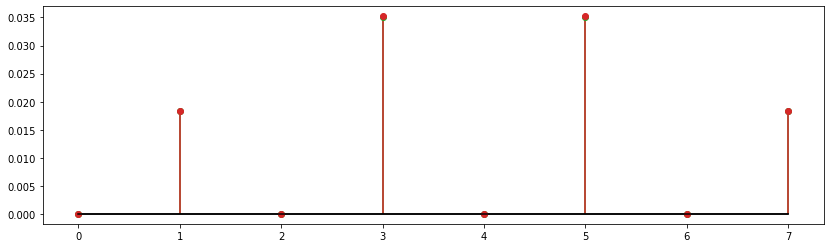

In [30]:
P = (3, 8, 2)
stem(nqe_sin_psd(*P), 'tab:green')
stem(nqe_sin_dfs(*P), 'tab:red')

Max NHD (theory):  0.014076477031128238
Max NHD (FFT):     0.014262281437017315


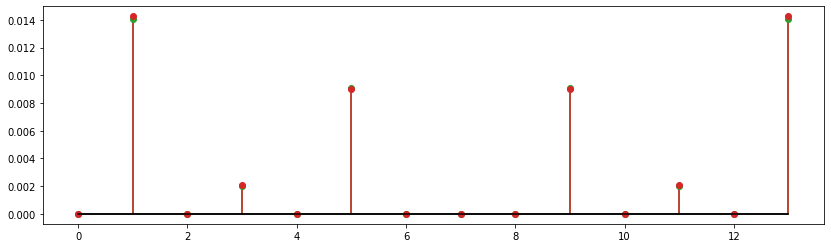

In [31]:
P = (5, 14, 3)
stem(nqe_sin_psd(*P), 'tab:green')
stem(nqe_sin_dfs(*P), 'tab:red')

### Case 2: irrational normalized frequency

Assume $\omega_0$ not a rational multiple of $2\pi$ 

 * the normalized frequency $\nu = \omega_0/(2\pi)$ will be an irrational number in $[0, 1)$
 
 * the set of _normalized_ frequencies $\Omega'(\nu) = \{(2m+1)\nu \mod 1\}_{m \in \mathbb{Z}} = \{ \langle (2m+1)\nu \rangle\}_{m \in \mathbb{Z}}$


Weil's Equidistribution theorem shows that $\Omega'(\nu)$ cover the entire $[0, 1]$ interval _uniformly_. 

In [145]:
P = (150, 1021, 2)
stem(nqe_sin_psd(*P), 'tab:green')
stem(nqe_sin_dfs(*P), 'tab:red')

NameError: name 'nqe_sin_psd' is not defined

# Back to the non-harmonic distortion patterns

Recall the plot of the maximum non-harmonic distortion as a function of normalized frequency and its curious "stepladder" pattern:

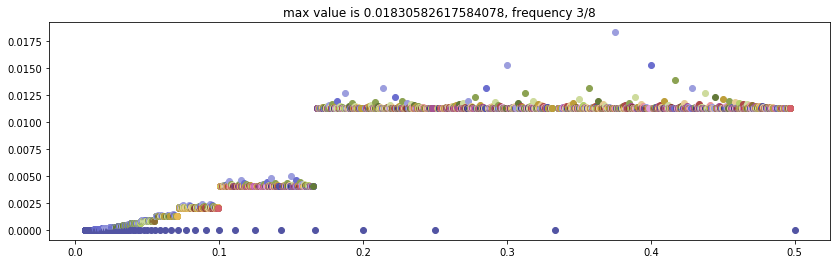

In [33]:
find_max_nhd(150, 2)

Consider the non-normalized quantization error for a sinusoid of frequency $\omega_0 = 2\pi\nu$, with $0 < \nu < 1/2$:

$$
\begin{align*}
    \frac{2}{M}\, \eta(\sin(2\pi\nu n))&= \sum_{m=-\infty}^{\infty} \left[ \frac{2}{M}\sum_{k = 1}^{\infty} \frac{(-1)^{kM}}{j\pi k}J_{2m+1}(\pi k M) \right] e^{j 2\pi(2m+1)\nu n} \\ 
      &= \sum_{m=-\infty}^{\infty} c_M(m)\, e^{j 2\pi(2m+1)\nu n};
\end{align*} 
$$

 * for $(2m+1)\nu < 1/2$ the PSD lines are harmonically related to the fundamental
 * for $(2m+1)\nu > 1/2$ we have aliasing and potentially non-harmonic distortion
 

$$
    \frac{2}{M}\, \eta(\sin(2\pi\nu n)) = \sum_{m=-\infty}^{\infty} c_M(m)\, e^{j 2\pi(2m+1)\nu n}
$$


 * the coefficients $c_M(m)$ depend only on the number of quantization levels $M$
 * $|c_M(m)|^2$ decreases rather quickly with $m$:

In [34]:
def c_m(N, M=2):
    k_lim = 600000
    s = [1, -1 if M % 2 == 1 else 1]
    c = np.zeros(N, dtype=complex)
    for m in range(0, N):
        for k in range(1, k_lim):
            c[m] += s[k % 2] * ss.jv(2 * m + 1, np.pi * k * M) / k
        c[m] /= 1j * np.pi
    return np.abs(c * (2 / M)) ** 2

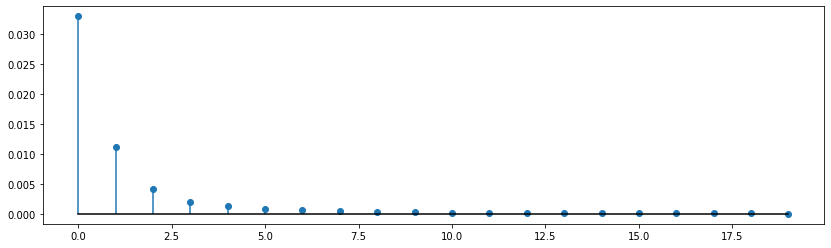

In [35]:
c2 = c_m(20, 2)
stem(c2)

 * the max NHD is dominated by the first aliased component:<br />max NHD is $|c_M(m_0)|^2$ where $m_0$ is the minimum integer for which $(2m_0+1)\nu > 1/2$. 



 * for $\nu > 1/6$, NHD $\approx |c_M(1)|^2$
 * for $1/10 < \nu < 1/6$, NHD $\approx |c_M(2)|^2$
 * ...

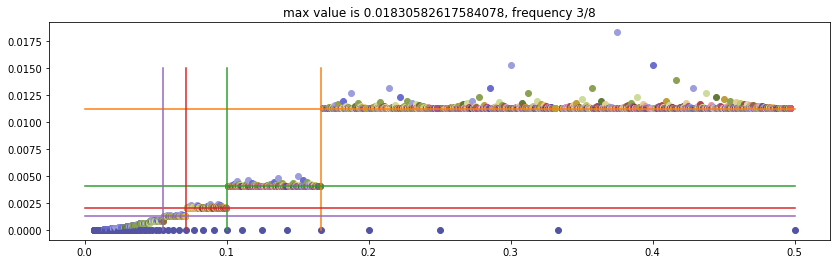

In [36]:
find_max_nhd(150, 2)
for m in range(1, 5):
    plt.plot([0.5/(2*m+1), 0.5/(2*m+1)], [0, 0.015], color=plt.cm.tab10(m))
    plt.plot([0, 0.5], [c2[m], c2[m]], color=plt.cm.tab10(m))

What about $M=3$ ? 

 * $c_3(2) \approx 0$
 * $c_3(m)$ non-monotonic
 * NHD approx the same for $1/18 < \nu < 1/6$.

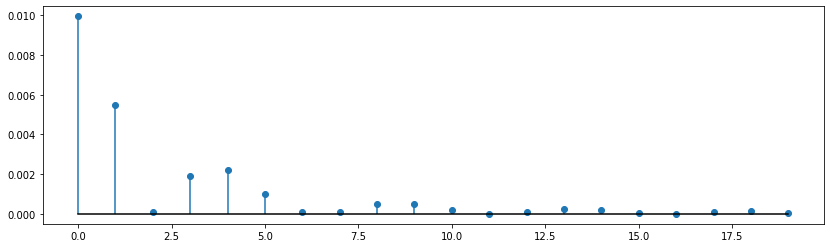

In [37]:
c3 = c_m(20, 3)
stem(c3)

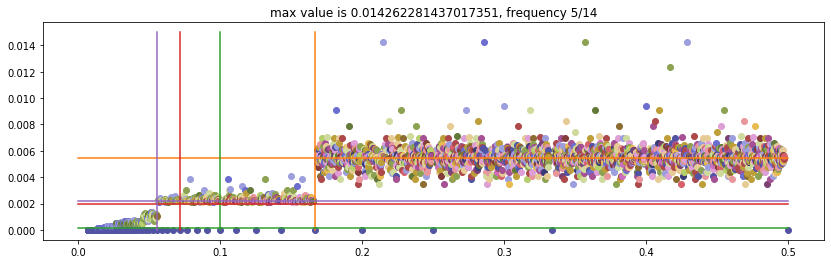

In [38]:
find_max_nhd(150, 3)
for m in range(1, 5):
    plt.plot([0.5/(2*m+1), 0.5/(2*m+1)], [0, 0.015], color=plt.cm.tab10(m))
    plt.plot([0, 0.5], [c3[m], c3[m]], color=plt.cm.tab10(m))

# COnclusionL Does all of this matter?

Yes and no:
 * it's important to understand the consequences of quantization
 * **dithering** techniques solve most of the problems we've seen here